In [55]:
import pandas as pd

data = pd.read_csv("titanic.tsv",sep="\t")
print(data)

     Survived  PassengerId  Pclass  \
0           0          530       2   
1           0          466       3   
2           0          753       3   
3           0          855       2   
4           0          333       1   
..        ...          ...     ...   
618         0          660       1   
619         1           85       2   
620         1          521       1   
621         1          644       3   
622         1          831       3   

                                               Name     Sex   Age  SibSp  \
0                      Hocking\t Mr. Richard George    male  23.0      2   
1                  Goncalves\t Mr. Manuel Estanslas    male  38.0      0   
2                 Vande Velde\t Mr. Johannes Joseph    male  33.0      0   
3    Carter\t Mrs. Ernest Courtenay (Lilian Hughes)  female  44.0      1   
4                        Graham\t Mr. George Edward    male  38.0      0   
..                                              ...     ...   ...    ...   
618        

In [56]:
# Przygotowanie danych:
# Age
data.loc[data['Age'].isna(), 'Age']=round(data.loc[:, 'Age'].mean(),2)
# Sex
data['Sex'].replace(['female','male'],[0,1],inplace=True)
# Name
for i in range(0,len(data.index)):
    row=data.loc[i,"Name"].split("\t ")[1]
    row=row.split()[0]
    data.loc[i,"Name"]=row
# Ticket
data.drop("Ticket", axis=1, inplace=True)
# Cabin
data["Cabin"] = data["Cabin"].astype(str).str[0]
# Embarked
data = data.dropna(axis=0, subset=['Embarked'])

In [57]:
data = pd.get_dummies(data, columns=["Pclass","Name","Embarked","Cabin"],drop_first = True)
print(data)

     Survived  PassengerId  Sex    Age  SibSp  Parch      Fare  Pclass_2  \
0           0          530    1  23.00      2      1   11.5000         1   
1           0          466    1  38.00      0      0    7.0500         0   
2           0          753    1  33.00      0      0    9.5000         0   
3           0          855    0  44.00      1      0   26.0000         1   
4           0          333    1  38.00      0      1  153.4625         0   
..        ...          ...  ...    ...    ...    ...       ...       ...   
618         0          660    1  58.00      0      2  113.2750         0   
619         1           85    0  17.00      0      0   10.5000         1   
620         1          521    0  30.00      0      0   93.5000         0   
621         1          644    1  29.36      0      0   56.4958         0   
622         1          831    0  15.00      1      0   14.4542         0   

     Pclass_3  Name_Col.  ...  Embarked_Q  Embarked_S  Cabin_B  Cabin_C  \
0           

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

columns = data.columns
#print(columns)
#Wszystkie cechy:
features=['PassengerId', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Pclass_2', 'Pclass_3', 'Name_Col.', 'Name_Don.', 'Name_Dr.',
       'Name_Lady.', 'Name_Major.', 'Name_Master.', 'Name_Miss.', 'Name_Mlle.',
       'Name_Mme.', 'Name_Mr.', 'Name_Mrs.', 'Name_Rev.', 'Name_Sir.',
       'Embarked_Q', 'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_n']
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

y_train = pd.DataFrame(data_train["Survived"]).to_numpy().reshape((-1,))
x_train = pd.DataFrame(data_train[features])

#Preprocessing
scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)

model=LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

y_expected = pd.DataFrame(data_test["Survived"])
x_test = pd.DataFrame(data_test[features])
x_test_scaled=scaler.transform(x_test)
y_predicted = model.predict(x_test_scaled)

In [59]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(
    y_expected, y_predicted, average="micro"
)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {fscore}")

score = model.score(x_test_scaled, y_expected)
print(f"Model score: {score}")

Precision: 0.784
Recall: 0.784
F-score: 0.7840000000000001
Model score: 0.784


In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, x_train_scaled, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)
scores.mean()

Cross-Validation Accuracy Scores [0.78       0.86       0.8        0.84       0.84       0.72
 0.83673469 0.79591837 0.91836735 0.83673469]


0.8227755102040817

In [61]:
from sklearn.feature_selection import RFE

model = LogisticRegression(random_state=42)
rfe = RFE(model, n_features_to_select=1)
rfe.fit(x_train_scaled, y_train)

feature_rankings = rfe.ranking_
feature_rankings_dict = {feature: rank for feature, rank in zip(features, feature_rankings)}
sorted_feature_rankings = sorted(feature_rankings_dict.items(), key=lambda x: x[1])

print("Feature Rankings:")
for feature, rank in sorted_feature_rankings:
    print(f"{feature}: {rank}")

Feature Rankings:
Name_Mr.: 1
Pclass_3: 2
SibSp: 3
Cabin_E: 4
Name_Rev.: 5
Age: 6
Fare: 7
Sex: 8
Name_Master.: 9
Cabin_D: 10
Embarked_S: 11
Name_Mrs.: 12
Parch: 13
Name_Sir.: 14
Name_Col.: 15
Cabin_n: 16
Name_Lady.: 17
PassengerId: 18
Cabin_G: 19
Name_Mlle.: 20
Cabin_C: 21
Name_Mme.: 22
Name_Miss.: 23
Pclass_2: 24
Cabin_F: 25
Embarked_Q: 26
Name_Dr.: 27
Name_Major.: 28
Cabin_B: 29
Name_Don.: 30
Cabin_T: 31


In [62]:
features2=['Name_Mr.','Pclass_3','SibSp','Cabin_E','Name_Rev.','Age'] #Wynik Cross-Validation: 0.834
#features2=['Name_Mr.','Pclass_3','SibSp','Cabin_E','Name_Rev.','Age',
                # 'Fare','Sex','Name_Master.','Cabin_D','Embarked_S',
                # 'Name_Mrs.','Parch','Name_Sir.','Name_Col.','Cabin_n'] #Wynik Cross-Validation: 0.830
#features2=['Name_Mr.','Pclass_3','SibSp','Cabin_E','Name_Rev.','Age',
                # 'Fare','Sex','Name_Master.','Cabin_D','Embarked_S',
                # 'Name_Mrs.','Parch','Name_Sir.','Name_Col.','Cabin_n','Name_Lady.'] #Wynik Cross-Validation: 0.830

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
x_train = pd.DataFrame(data_train[features2])
y_train = pd.DataFrame(data_train["Survived"]).to_numpy().reshape((-1,))

#Preprocessing
scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)

model2 = LogisticRegression(random_state=42)
model2.fit(x_train_scaled, y_train)

y_expected = pd.DataFrame(data_test["Survived"])
x_test = pd.DataFrame(data_test[features2])
x_test_scaled=scaler.transform(x_test)
y_predicted = model2.predict(x_test_scaled)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model2, x_train_scaled, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)
scores.mean()

Cross-Validation Accuracy Scores [0.84       0.9        0.78       0.88       0.84       0.7
 0.85714286 0.7755102  0.91836735 0.85714286]


0.8348163265306123

In [63]:
data.describe()[["Age","Fare"]]

,Age,Fare
count,621.000000,621.000000
mean,29.289919,30.197759
std,12.971010,43.890790
min,0.420000,0.000000
25%,22.000000,7.925000
50%,29.360000,14.454200
75%,34.500000,30.070800
max,74.000000,512.329200


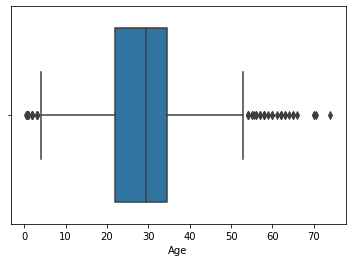

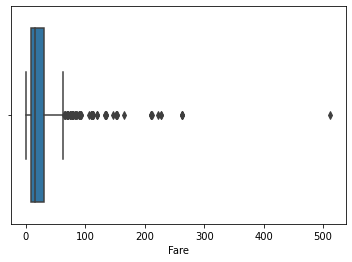

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x=data['Age'])
plt.show()
sns.boxplot(x=data['Fare'])
plt.show()

In [65]:
#Usuwanie części wartości odstających
q_low = data["Age"].quantile(0.02)
q_hi  = data["Age"].quantile(0.98)

data_filtered1 = data[(data["Age"] < q_hi) & (data["Age"] > q_low)]
q_low = data_filtered1["Fare"].quantile(0.02)
q_hi  = data_filtered1["Fare"].quantile(0.98)
#data_filtered2=data_filtered1[(data_filtered1["Fare"] < q_hi) & (data_filtered1["Fare"] > q_low)]
data_filtered2=data_filtered1[(data_filtered1["Fare"] < 100)]
filtered = pd.merge(data_filtered2, data)
print(f"Usunięto {len(data)-len(filtered)} wierszy")

Usunięto 60 wierszy


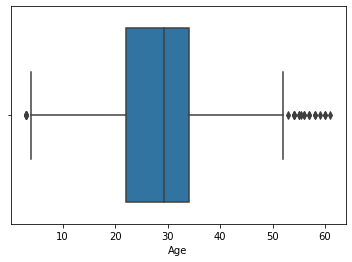

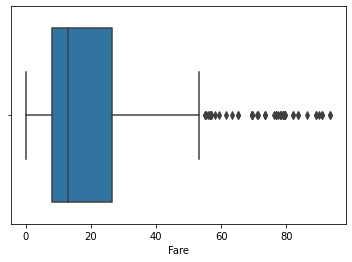

In [66]:
sns.boxplot(x=filtered['Age'])
plt.show()
sns.boxplot(x=filtered['Fare'])
plt.show()

In [67]:
print("Dane dotyczące Age i Fare przed usunięciem wartości odstających:")
display(data.describe()[["Age","Fare"]])
print("Dane dotyczące Age i Fare po usunięciu wartości odstających:")
display(filtered.describe()[["Age","Fare"]])

Dane dotyczące Age i Fare przed usunięciem wartości odstających:


,Age,Fare
count,621.000000,621.000000
mean,29.289919,30.197759
std,12.971010,43.890790
min,0.420000,0.000000
25%,22.000000,7.925000
50%,29.360000,14.454200
75%,34.500000,30.070800
max,74.000000,512.329200


Dane dotyczące Age i Fare po usunięciu wartości odstających:


,Age,Fare
count,561.000000,561.000000
mean,29.045811,21.617238
std,11.266149,20.107884
min,3.000000,0.000000
25%,22.000000,7.895800
50%,29.360000,13.000000
75%,34.000000,26.550000
max,61.000000,93.500000


In [68]:
'''features=['PassengerId', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Pclass_2', 'Pclass_3', 'Name_Col.', 'Name_Don.', 'Name_Dr.',
       'Name_Lady.', 'Name_Major.', 'Name_Master.', 'Name_Miss.', 'Name_Mlle.',
       'Name_Mme.', 'Name_Mr.', 'Name_Mrs.', 'Name_Rev.', 'Name_Sir.',
       'Embarked_Q', 'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_n']''' #Wynik Cross-Validation: 0.803
features=features2

data_train, data_test = train_test_split(filtered, test_size=0.2, random_state=42)

y_train = pd.DataFrame(data_train["Survived"]).to_numpy().reshape((-1,))
x_train = pd.DataFrame(data_train[features])

#Preprocessing
scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)

model=LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

y_expected = pd.DataFrame(data_test["Survived"])
x_test = pd.DataFrame(data_test[features])
x_test_scaled=scaler.transform(x_test)
y_predicted = model.predict(x_test_scaled)

In [69]:
precision, recall, fscore, support = precision_recall_fscore_support(
    y_expected, y_predicted, average="micro"
)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {fscore}")

score = model.score(x_test_scaled, y_expected)
print(f"Model score: {score}")

Precision: 0.8407079646017699
Recall: 0.8407079646017699
F-score: 0.8407079646017699
Model score: 0.8407079646017699


In [70]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, x_train_scaled, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)
scores.mean()

Cross-Validation Accuracy Scores [0.84444444 0.86666667 0.75555556 0.84444444 0.77777778 0.8
 0.82222222 0.77777778 0.81818182 0.86363636]


0.8170707070707071